In [1]:
import numpy as np
import pandas as pd
import os, time, logging
import matplotlib.pyplot as plt
from IPython.display import clear_output
from src.data import Hicmat, plot_data, preprocess_data
from src.tad_algo import TopDom, TADtree
from src.consensus import *
from src.ctcf import *
from src.utils import *

# Load files and prepare displaying

In [2]:
resolution=100000

In [3]:
tads_by_tadtree = (pd.read_csv('N399.txt', delimiter='\t')).iloc[:, [1,2]]
tadtree = [(tads_by_tadtree['start'][i], tads_by_tadtree['end'][i]) for i in range(len(tads_by_tadtree['start']))]

In [4]:
folder = os.path.join('..', 'CHROMOSOMES', 'GM12878', '100kb')
data_path = os.path.join(folder, 'chr1_100kb.npy')
if not os.path.isfile(data_path):
    preprocess_data(folder, resolution)
hic_mat = Hicmat(data_path, resolution)
hic_mat.filter(threshold = 1)
topdom = TopDom()
topdom = topdom.getTADs(hic_mat, window=3)
for i in range(len(topdom)):
    topdom[i]=(int(topdom[i][0]/resolution), int(topdom[i][1]/resolution))

TopDom Step 1 : Generating binSignals by computing bin-level contact frequencies
TopDom Step 2 : Detect TD boundaries based on binSignals
TopDom Step 3 : Statistical Filtering of false positive TD boundaries
TopDom : Exporting TADs


In [5]:
fileCTCF = os.path.join('..', 'CTCF', 'ENCFF796WRU.bed')
l_peak_GM = bedPicks(fileCTCF, 'chr1', resolution)[0]
true_results = read_arrowhead_result(os.path.join('..', 'RESULTS', 'GSE63525_GM12878_primary+replicate_Arrowhead_domainlist.txt'), '1', resolution)

# Test the consensus on tadtree+topdom

In [6]:
tadtree_topdom = {'tadtree':tadtree, 'topdom':topdom}

In [7]:
size = []
evaluation = []
for threshold in range(400):
    clear_output(wait=True)
    print(threshold+1, '/ 400')
    cons1 = consensus(tadtree_topdom, resolution, threshold)
    size.append(len(cons1))
    ev = evaluate(list(cons1.keys()), l_peak_GM)
    if ev==0:
        evaluation.append(100)
    else:
        evaluation.append(ev)

400 / 400


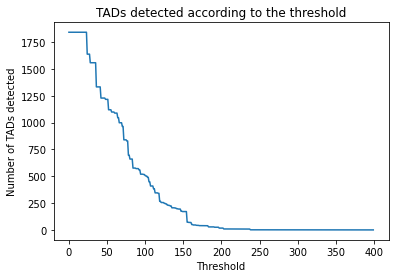

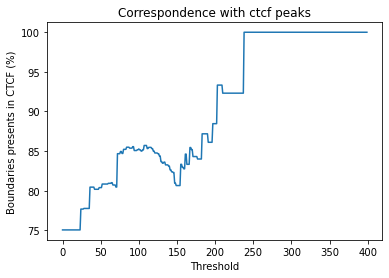

In [8]:
plt.title('TADs detected according to the threshold')
plt.plot(range(400), size)
plt.xlabel('Threshold')
plt.ylabel('Number of TADs detected')
plt.show()
plt.title('Correspondence with ctcf peaks')
plt.plot(range(400), evaluation)
plt.xlabel('Threshold')
plt.ylabel('Boundaries presents in CTCF (%)')
plt.show()

### Evaluation with a threshold = 110

In [9]:
threshold = 110
cons_topdom_tadtree = consensus(tadtree_topdom, resolution, threshold)
print('TADs detected:', len(cons_topdom_tadtree))
print('Similarity rate with CTCF peaks:', evaluate(cons_topdom_tadtree, l_peak_GM), '%')

TADs detected: 409
Similarity rate with CTCF peaks: 85.71 %


In [10]:
gap = 1
print('rate of TADs find in ArrowHead :', compare_TADs(list(cons_topdom_tadtree.keys()), true_results, gap)*100, '%')

rate of TADs find in ArrowHead : 64.79217603911981 %


# Test the consensus on tadtree+topdom+arrowhead

In [11]:
tadtree_topdom_arrowhead = {'tadtree':tadtree, 'topdom':topdom, 'arrowhead':true_results}

In [12]:
size = []
evaluation = []
for threshold in range(600):
    clear_output(wait=True)
    print(threshold+1, '/ 600')
    cons2 = consensus(tadtree_topdom_arrowhead, resolution, threshold)
    size.append(len(cons2))
    ev = evaluate(list(cons2.keys()), l_peak_GM)
    if ev==0:
        evaluation.append(100)
    else:
        evaluation.append(ev)

600 / 600


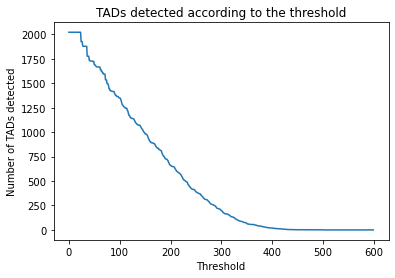

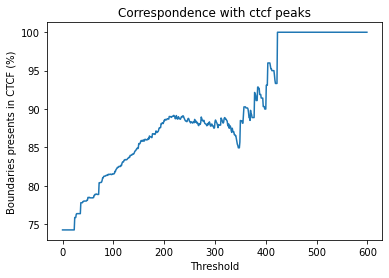

In [13]:
plt.title('TADs detected according to the threshold')
plt.plot(range(600), size)
plt.xlabel('Threshold')
plt.ylabel('Number of TADs detected')
plt.show()
plt.title('Correspondence with ctcf peaks')
plt.plot(range(600), evaluation)
plt.xlabel('Threshold')
plt.ylabel('Boundaries presents in CTCF (%)')
plt.show()

### Evaluation with a threshold = 260

In [14]:
threshold = 260
cons_topdom_tadtree_arrowhead = consensus(tadtree_topdom_arrowhead, resolution, threshold)
print('TADs detected:', len(cons_topdom_tadtree_arrowhead))
print('Similarity rate with CTCF peaks:', evaluate(cons_topdom_tadtree_arrowhead, l_peak_GM), '%')

TADs detected: 355
Similarity rate with CTCF peaks: 88.64999999999999 %


In [15]:
gap = 1
print('rate of TADs find in ArrowHead :', compare_TADs(list(cons_topdom_tadtree_arrowhead.keys()), true_results, gap)*100, '%')

rate of TADs find in ArrowHead : 79.71830985915493 %


# Explanation of scoring

In [19]:
eval_topdom = []
eval_arrowhead = []
for cell_type in ['GM12878', 'HMEC', 'HUVEC', 'IMR90', 'NHEK']:
    ctcf = {
        'GM12878':'ENCFF796WRU.bed',
        'HMEC':'ENCFF059YXD.bed',
        'HUVEC':'ENCFF949KVG.bed',
        'IMR90':'ENCFF203SRF.bed',
        'NHEK':'ENCFF351YOQ.bed'
    }
    fileCTCF = os.path.join('CTCF', cell_type, ctcf[cell_type])
    l_peak = bedPicks(fileCTCF, 'chr1', resolution)[0]
    folder = os.path.join('..', 'CHROMOSOMES', cell_type, '100kb')
    data_path = os.path.join(folder, 'chr1_100kb.npy')
    if not os.path.isfile(data_path):
        preprocess_data(folder, resolution)
    hic_mat = Hicmat(data_path, resolution)
    hic_mat.filter(threshold = 1)
    topdom_i = TopDom()
    topdom_i = topdom_i.getTADs(hic_mat, window=3)
    for i in range(len(topdom_i)):
        topdom_i[i]=(int(topdom_i[i][0]/resolution), int(topdom_i[i][1]/resolution))
    eval_topdom.append(evaluate(topdom_i, l_peak))
    arrowhead = {
        'GM12878':'GSE63525_GM12878_primary+replicate_Arrowhead_domainlist.txt',
        'HMEC':'GSE63525_HMEC_Arrowhead_domainlist.txt',
        'HUVEC':'GSE63525_HUVEC_Arrowhead_domainlist.txt',
        'IMR90':'GSE63525_IMR90_Arrowhead_domainlist.txt',
        'NHEK':'GSE63525_NHEK_Arrowhead_domainlist.txt'
    }
    true_results_i = read_arrowhead_result(os.path.join('..', 'RESULTS', arrowhead[cell_type]), '1', resolution)
    eval_arrowhead.append(evaluate(true_results_i, l_peak))
    clear_output()

In [20]:
print('score for topdom :', np.mean(eval_topdom))
print('score for arrowhead :', np.mean(eval_arrowhead))
print('score for tadtree :', evaluate(tadtree, l_peak_GM))

score for topdom : 71.26
score for arrowhead : 78.58200000000001
score for tadtree : 83.23
